In [1]:
import numpy as np

from scipy.io import loadmat

import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load and Process Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

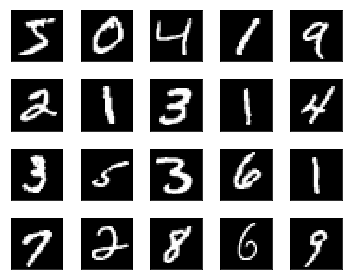

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

### Generator

In [6]:
def make_generator(input_size, leaky_alpha):
    return Sequential([
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
       
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

### Discriminator

In [7]:
def make_discriminator(leaky_alpha):
    return Sequential([        
       
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        
        Dense(1),
        Activation('sigmoid')        
    ])

### DCgans

In [8]:
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [9]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])


In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [14]:
def train(
    g_learning_rate,   
    g_beta_1,          
    d_learning_rate,   
    d_beta_1,          
    leaky_alpha,
    smooth=0.1,        
    sample_size=100,   
    epochs=25,
    batch_size=128,    
    eval_size=16,      
    show_details=True):
    
  
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)


    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
         
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

           
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

       
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

       
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

       
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) #

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

/home/hvyd/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/25 Discriminator Loss: 1.5634 Generator Loss: 1.3659
Epoch:  2/25 Discriminator Loss:16.1181 Generator Loss:16.1181
Epoch:  3/25 Discriminator Loss: 5.9966 Generator Loss:16.1181
Epoch:  4/25 Discriminator Loss: 9.7116 Generator Loss:13.0484
Epoch:  5/25 Discriminator Loss: 3.8727 Generator Loss: 8.8546
Epoch:  6/25 Discriminator Loss: 7.9981 Generator Loss: 7.4961
Epoch:  7/25 Discriminator Loss:12.3012 Generator Loss:13.0019
Epoch:  8/25 Discriminator Loss:10.4077 Generator Loss:10.3994
Epoch:  9/25 Discriminator Loss: 7.1994 Generator Loss: 7.2883
Epoch: 10/25 Discriminator Loss: 8.2701 Generator Loss: 9.2411


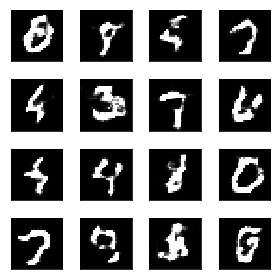

Epoch: 11/25 Discriminator Loss:11.5170 Generator Loss:12.4052
Epoch: 12/25 Discriminator Loss:14.8931 Generator Loss:15.6678
Epoch: 13/25 Discriminator Loss:13.4088 Generator Loss:15.9180
Epoch: 14/25 Discriminator Loss:12.9478 Generator Loss:13.7004
Epoch: 15/25 Discriminator Loss: 9.3546 Generator Loss: 8.4604
Epoch: 16/25 Discriminator Loss: 6.1096 Generator Loss: 6.5464
Epoch: 17/25 Discriminator Loss: 4.2559 Generator Loss: 4.9377
Epoch: 18/25 Discriminator Loss: 4.4252 Generator Loss: 4.7559
Epoch: 19/25 Discriminator Loss: 5.9483 Generator Loss: 6.5168
Epoch: 20/25 Discriminator Loss: 6.8873 Generator Loss: 7.3425


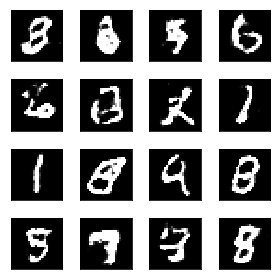

Epoch: 21/25 Discriminator Loss: 3.2256 Generator Loss: 3.0834
Epoch: 22/25 Discriminator Loss: 3.2370 Generator Loss: 4.9340
Epoch: 23/25 Discriminator Loss: 7.1225 Generator Loss: 7.8361
Epoch: 24/25 Discriminator Loss: 4.0457 Generator Loss: 4.0573
Epoch: 25/25 Discriminator Loss: 3.6117 Generator Loss: 5.1679


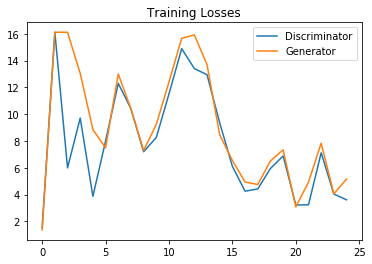

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01)